In [1]:
import pandas as pd
import numpy as np

-7200
Etc/GMT+2
-7200
Etc/GMT+2
-7200
Etc/GMT+2
-7200
Etc/GMT+2


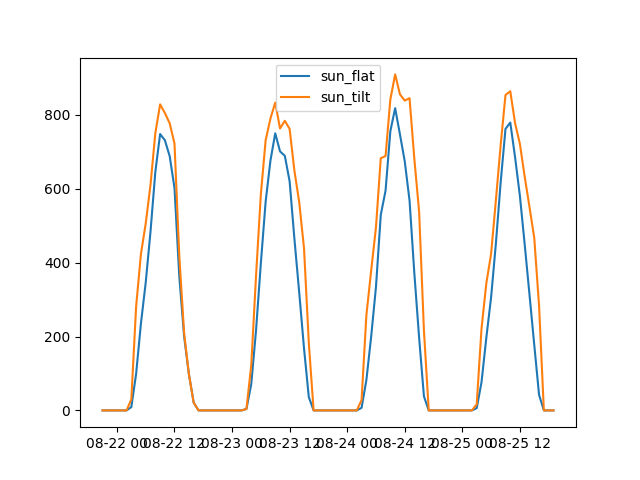

In [118]:
import requests
from datetime import datetime
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt
%matplotlib widget

to_dates = np.vectorize(datetime.fromtimestamp)
tzfinder = TimezoneFinder()

def get_openmeteo(latlong, vars, start:datetime, stop:datetime):

    #get timezone at coordinate so timestamps make sense
    timezone = tzfinder.timezone_at(lat=latlong[0], lng=latlong[1])

    forecast = {}
    for var in vars:

        response = requests.request(
            method = "GET", 
            url = "https://api.open-meteo.com/v1/forecast?", 
            params = {
                "latitude": latlong[0],
                "longitude": latlong[1],
                "hourly": var,
                "windspeed_unit": "ms",
                "start_date": start.strftime("%Y-%m-%d"),
                "end_date": stop.strftime("%Y-%m-%d"),
                "timeformat": "unixtime",
                "timezone": timezone
            }
        ).json()

        data = response['hourly']
        values = np.array(data[var])

        if('dates' not in forecast):
            #get index of the last value that isn't None
            none_pos = [-i for i in range(len(values)) if values[-i] == None]
            last_pos = -1 if len(none_pos)==0 else none_pos[-1]

            #truncate the Nones at the end
            timestamps = np.array(data['time'])[:last_pos]
            values = values[:last_pos]

            forecast['dates'] = to_dates(timestamps)   

        forecast['var'] = values
    
    return forecast


weather = {}
for var in ['shortwave_radiation', 'direct_radiation', 'direct_normal_irradiance', 'diffuse_radiation']:

    forecast = get_openmeteo((40.11, -33), var, datetime(2022, 8, 22), datetime(2022, 8, 25))

    if 'dates' not in weather:
        weather['dates'] = forecast['dates']
    
    weather[var] = forecast['values']

weather['sun_flat'] = weather['shortwave_radiation']
weather['sun_tilt'] = weather['direct_normal_irradiance'] + weather['diffuse_radiation']

plt.figure()
plt.plot(weather['dates'], weather['sun_flat'], label='sun_flat')
plt.plot(weather['dates'], weather['sun_tilt'], label='sun_tilt')

plt.legend()
